In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
#train, test directories
train_dir = "D:/Github/Datasets/daisy dandelion/train"
test_dir = "D:/Github/Datasets/daisy dandelion/test"

**Create Datasets and DataLoaders**

In [6]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
        train_dir: str,
        test_dir: str,
        transform: transforms.Compose,
        batch_size: int,
        num_workers: int=NUM_WORKERS
):
    
    #Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    #Get Class Names
    class_names = train_data.classes

    #Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_dataloader, test_dataloader, class_names

In [7]:
#Create Img size
IMG_SIZE = 224

#Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [10]:
#Set the batch size
BATCH_SIZE = 32

#create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
    transform=manual_transforms,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2c6d3ed21d0>,
 ['daisy', 'dandelion'])

In [11]:
#Let's check if data is loaded or not

#Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

#Get a single image from batch
image, label = image_batch[0], label_batch[0]

#View the batch shapes
print(image.shape, label)

torch.Size([3, 224, 224]) tensor(1)


(-0.5, 223.5, 223.5, -0.5)

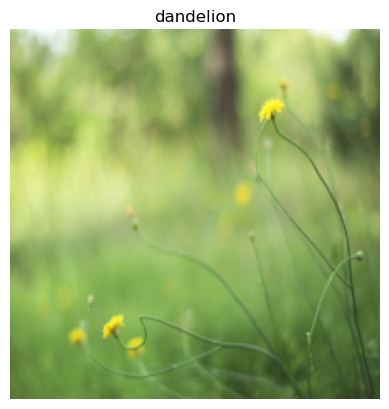

In [12]:
#plot the image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

**Step 1**

1.Turn an image into patches

2.Flatten the patch feature maps into a single dimension

3.Convert the output into desired output (flattened 2D patches): (196,768) -> Nx(P2-C) #Current Shape: (1,768,196)

In [17]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

**PatchEmbedding Layer Ready**

In [18]:
# Let's test it on single image
patch_size =16

# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)
    
    
    
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [20]:
#view the patch embedding and patch embedding shape

print(patch_embedded_image)
print(f'Patch Embedding Shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]')

tensor([[[-0.8086,  0.3047, -0.2211,  ...,  0.5893, -0.3869,  0.2505],
         [-0.9282,  0.2857, -0.1407,  ...,  0.7109, -0.4631,  0.2498],
         [-0.6391,  0.0854, -0.1606,  ...,  0.5512, -0.4040,  0.3686],
         ...,
         [-0.3491,  0.1179, -0.1126,  ...,  0.2352, -0.1620,  0.1022],
         [-0.2715,  0.0858, -0.1082,  ...,  0.2044, -0.1498,  0.1159],
         [-0.2905,  0.0865, -0.1016,  ...,  0.1934, -0.1123,  0.1401]]],
       grad_fn=<PermuteBackward0>)
Patch Embedding Shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [24]:
# Now add the learnale class embedding position embeddings
# From start to positional encoding: All in 1 cell

set_seeds()

# 1.Set patch size
patch_size = 16

# 2.Print shape of original image ttensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3.Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}") #add an extra batch dimension on the 0th index, otherwise will error

# 4.Create Patch embedding layer
patch_embedded_layer = PatchEmbedding(in_channels=3,
                                      patch_size=patch_size,
                                      embedding_dim=768)

# 5.Pass image through patch embeddig layer
patch_embedding = patch_embedded_layer(x)
print(f'Patch Embedding shape: {patch_embedding.shape}')

# 6.Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True) #make sure its learnable
print(f'Class token embedding shape: {class_token.shape}')

# 7.Prepend clss token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

# 8.Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad = True) #make sure its learnable

# 9.Add position embedding to patch embedding with class token
patch_and_positon_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_positon_embedding.shape}')

print(patch_embedding_class_token) #1 is added in the beginning of each

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patch Embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8086,  0.3047, -0.2211,  ...,  0.5893, -0.3869,  0.2505],
         [-0.9282,  0.2857, -0.1407,  ...,  0.7109, -0.4631,  0.2498],
         ...,
         [-0.3491,  0.1179, -0.1126,  ...,  0.2352, -0.1620,  0.1022],
         [-0.2715,  0.0858, -0.1082,  ...,  0.2044, -0.1498,  0.1159],
         [-0.2905,  0.0865, -0.1016,  ...,  0.1934, -0.1123,  0.1401]]],
       grad_fn=<CatBackward0>)


Here we're only creating the class token embedding as torch.ones() for demonstration. In reality, you'd likely create the class token embedding with **torch.rand**.